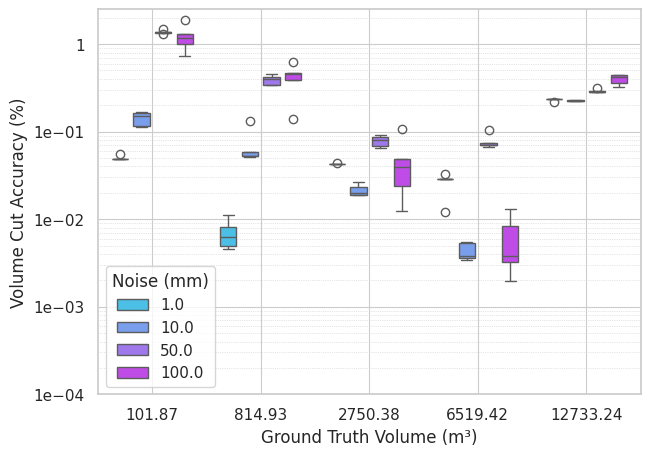

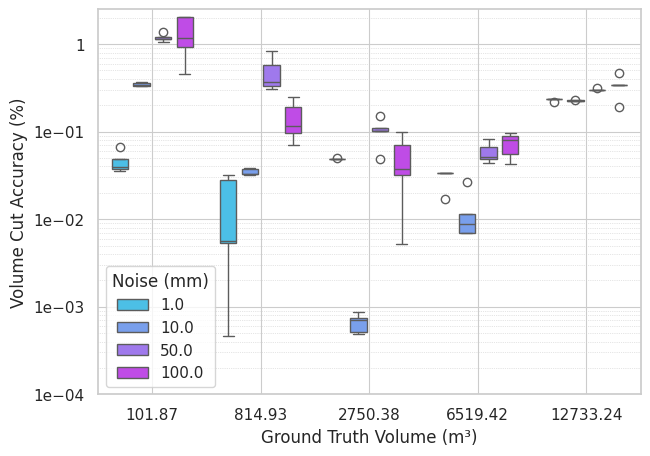

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pipeline  # Ensure this is in your Python path
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, LogFormatter

# Load the CSV file
results_df_list = [pd.read_csv("results_0_5_1.csv"), pd.read_csv("results_0_30_5.csv")]


# Define a helper function to compute the ground truth volume
def compute_gt_vol(row):
    sigma = row["radius"] / 2.0
    return pipeline.get_analytical_volume(sigma, row["radius"], row["max_depth"]).round(
        2
    )

for results_df in results_df_list:

    results_df["gt_vol"] = results_df.apply(compute_gt_vol, axis=1)

    # Create a noise_std_mm column (noise in millimeters) and absolute accuracy, 2 digits
    results_df["noise_std_mm"] = results_df["noise_std"] * 1000
    results_df["volume_cut_acc_positive"] = results_df["volume_cut_acc"].abs()

    # Set the theme with a white grid and define an improved color palette.
    sns.set_theme(style="whitegrid")
    unique_noise = results_df["noise_std_mm"].unique()
    palette = sns.color_palette("cool", n_colors=len(unique_noise))

    plt.figure(figsize=(7, 5))
    ax = plt.gca()

    # Create a grouped boxplot with the improved palette
    sns.boxplot(
        x="gt_vol",
        y="volume_cut_acc_positive",
        hue="noise_std_mm",
        data=results_df,
        ax=ax,
        palette=palette,
        widths=0.15,
    )

    ax = plt.gca()
    ax.set_yscale("log")

    # Force a y-limit that covers at least two decades, so we can see more ticks
    ax.set_ylim(1e-4, 5)

    # Major ticks at powers of 10
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,), numticks=10))
    ax.yaxis.set_major_formatter(LogFormatter())

    # Minor ticks at 2,3,4,5,6,7,8,9 times each power of 10
    ax.yaxis.set_minor_locator(
        LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=12)
    )
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    ax.grid(which="major", linewidth=0.8)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)

    plt.xlabel("Ground Truth Volume (m³)")
    plt.ylabel("Volume Cut Accuracy (%)")
    plt.legend(title="Noise (mm)", loc="best")
    plt.savefig(f"final.png", dpi=300, bbox_inches="tight")
    plt.show()

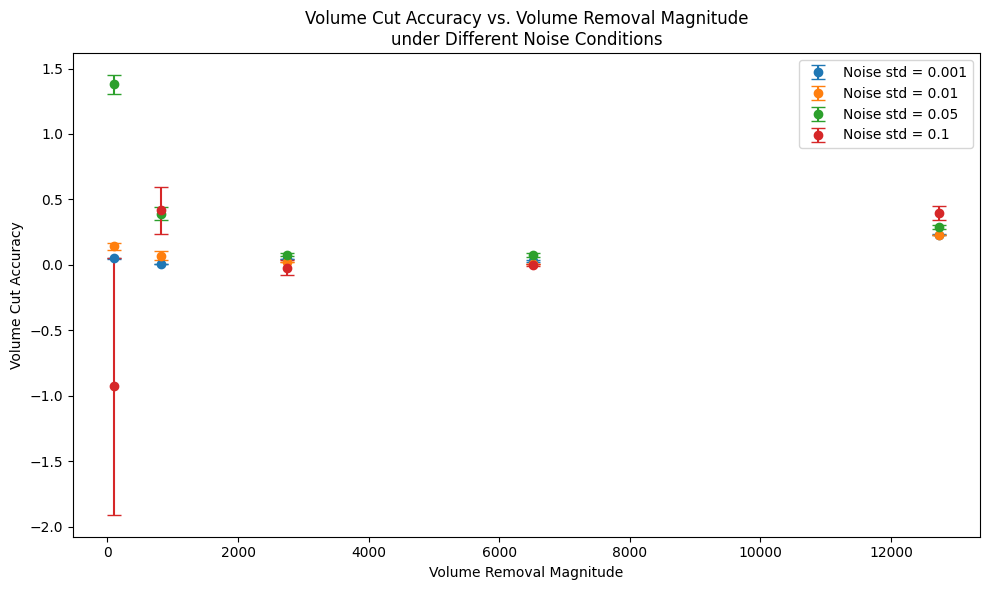

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pipeline

# Read CSV data.
# You can save your CSV data to a file (e.g., 'data.csv') and update the path below.
df = pd.read_csv('results_0_5_1.csv')

# Compute sigma from radius
df['sigma'] = df['radius'] / 2.0

# Compute volume removal magnitude using our placeholder function
df['volume_removal'] = df.apply(lambda row: pipeline.get_analytical_volume(row['sigma'], row['radius'], row['max_depth']), axis=1)

# Group the data by volume_removal and noise condition (each group has 5 runs)
grouped = df.groupby(['volume_removal', 'noise_std']).agg(
    mean_volume_cut_acc=('volume_cut_acc', 'mean'),
    std_volume_cut_acc=('volume_cut_acc', 'std')
).reset_index()

# Plot: use different markers (and colors) for each noise condition.
plt.figure(figsize=(10, 6))
for noise in grouped['noise_std'].unique():
    subset = grouped[grouped['noise_std'] == noise]
    plt.errorbar(subset['volume_removal'], subset['mean_volume_cut_acc'],
                 yerr=subset['std_volume_cut_acc'], fmt='o', capsize=5,
                 label=f'Noise std = {noise}')

plt.xlabel('Volume Removal Magnitude')
plt.ylabel('Volume Cut Accuracy')
plt.title('Volume Cut Accuracy vs. Volume Removal Magnitude\nunder Different Noise Conditions')
plt.legend()
plt.tight_layout()
plt.show()